# Exploring convex optimization

With CVXPY.

In [1]:
import cvxpy as cp
import numpy as np

from pprint import pprint

---

Trivial linear program example.

In [2]:
x, y = cp.Variable(), cp.Variable()

constraints = [
    x >= 1,
    y <= -1,
]

objective = cp.Minimize((x - y) ** 2)

problem = cp.Problem(objective, constraints)
problem.solve()

pprint({
    'status': problem.status,
    'value':  problem.value,
    'x': x.value,
    'y': y.value,
})

{'status': 'optimal', 'value': 4.0, 'x': array(1.), 'y': array(-1.)}


---

Optimal transport linear program.

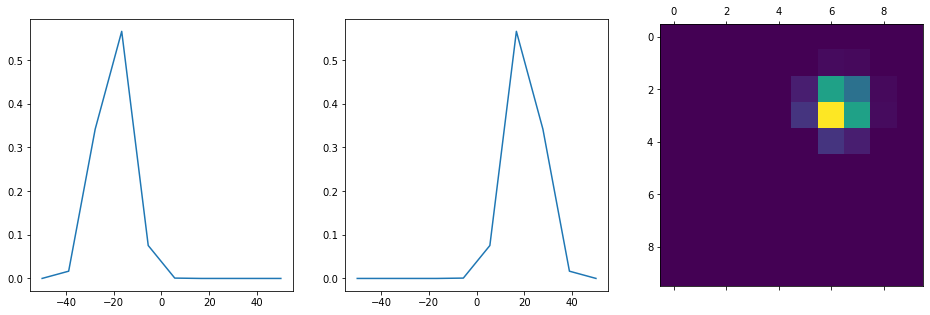

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm


n, m = 10, 10
x = np.linspace(-50, 50, n)
y = np.linspace(-50, 50, m)

u = norm.pdf(x, loc=-20, scale=7)
u /= u.sum()
v = norm.pdf(y, loc=20, scale=7)
v /= v.sum()

C = np.abs(np.subtract.outer(x, y))

def ot(u, v, C):
    pi = cp.Variable((n, m))

    constraints = [
        cp.sum(pi, axis=1) == u,
        cp.sum(pi, axis=0) == v,
        pi >= 0
    ]

    objective = cp.Minimize(cp.sum_squares(cp.multiply(pi, C)))

    problem = cp.Problem(objective, constraints)
    problem.solve()

    return pi.value

pi = ot(u, v, C)

fig, (a1, a2, a3) = plt.subplots(1, 3, figsize=(16, 5))
a1.plot(x, u)
a2.plot(y, v)
a3.matshow(pi)

In [75]:
from numba import njit


@njit
def argnmax(a: np.ndarray):
    i1, i2 = -1, -1
    v1, v2 = -np.inf, -np.inf

    for i in range(len(a)):
        if a[i] > v1:
            v2 = v1
            i2 = i1

            v1 = a[i]
            i1 = i

    return i1, i2

@njit
def auction(A: np.ndarray):
    N = len(A)
    p = np.zeros(N)
    eps = 1 / N / 2

    assignment = dict()         # obj to person
    unassigned = set(range(N))  # unassigned people

    while unassigned:
        i = unassigned.pop()

        m = A[i] - p
        v, w = argnmax(m)
        p[v] = p[v] + eps + m[v] - m[w]

        if v in assignment:
            unassigned.add(int(assignment.pop(v)))

        assignment[v] = i

    # numba doesn't support comprehensions
    rev = {}
    for k, v in assignment.items():
        rev[v] = k

    return rev

In [77]:
n = 500
A = np.random.randint(10, size=(n, n)).astype(int)

%timeit auction(A)

420 µs ± 719 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Entropic regularized optimal transport problem.

[[0.1 0.  0.  0. ]
 [0.1 0.1 0.  0. ]
 [0.1 0.1 0.1 0. ]
 [0.1 0.1 0.1 0.1]]


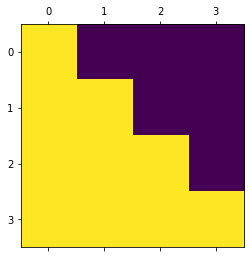

In [78]:
def ot(r, c, M, lmbda, eps=1e-5):
    K = np.exp(- lmbda * M)
    Kt = np.diag(1 / r.ravel()) @ K

    u = np.ones((len(r), 1)) / len(r)
    lu = u

    converged = False
    while not converged:
        u = 1 / (Kt @ (c[:, np.newaxis] / (K.T @ u)))
        converged = np.sum((u - lu) ** 2) < len(r) * eps
        lu = u

    v = c[:, np.newaxis] / (K.T @ u)
    return u * K * v.T


r = np.asarray([0.1, 0.2, 0.3, 0.4])
c = np.asarray([0.4, 0.3, 0.2, 0.1])
x = np.arange(4)
M = np.abs(np.subtract.outer(x, x))

P = ot(r, c, M, 5)
plt.matshow(P)

print(P.round(3))